## Transfer Learning- ResNet

In this tutorial, you will learn how to classify CIFAR100 by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

In [34]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [35]:
plt.rcParams['figure.figsize'] = (18,8)

In [36]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [37]:
X_train.shape

(50000, 32, 32, 3)

In [38]:
y_train.shape

(50000, 1)

In [39]:
X_test.shape

(10000, 32, 32, 3)

In [40]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.8)

In [41]:
cifar100_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [42]:
X_train[0].shape

(32, 32, 3)

In [43]:
y_train[1].astype(int)[0]

29

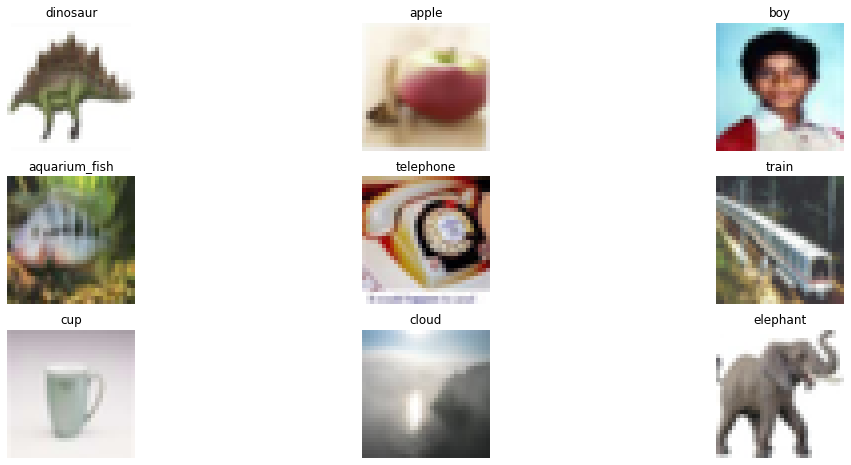

In [45]:
for img in range(1,10):
    plt.subplot(3,3,img)
    plt.imshow(X_train[img])
    plt.title(cifar100_classes[y_train[img][0]])
    plt.axis("off")

In [46]:
#one hot encoding matrix- scaling of Categorical Dataset

y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)
y_valid = keras.utils.to_categorical(y_valid, 100)

In [47]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Data Augmentation

A data augmentation strategy provides training models with dramatically greater diversity in terms of data available, without actually being filled with new data, at no cost to practitioners. Training neural networks is commonly achieved with cropping, padding, and horizontal flipping methods.

In [48]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])

2022-08-22 23:53:03.236250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 23:53:03.236274: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 23:53:03.236288: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucifertrj): /proc/driver/nvidia/version does not exist
2022-08-22 23:53:03.236498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


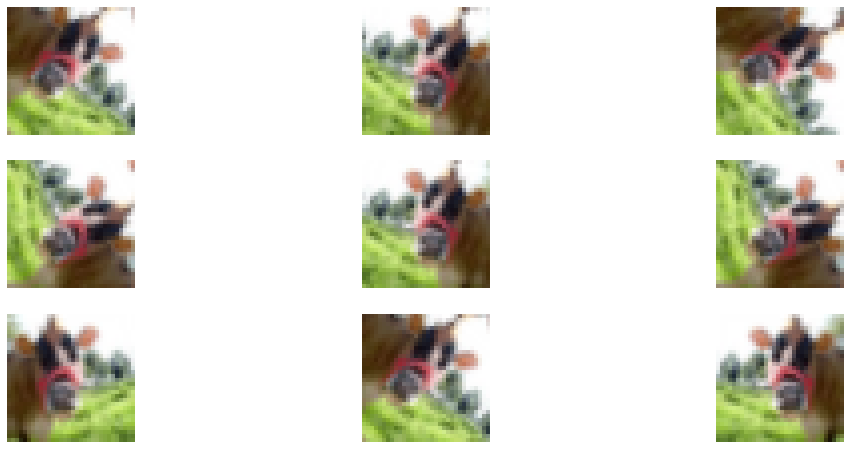

In [49]:
for image in X_train[:1]:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

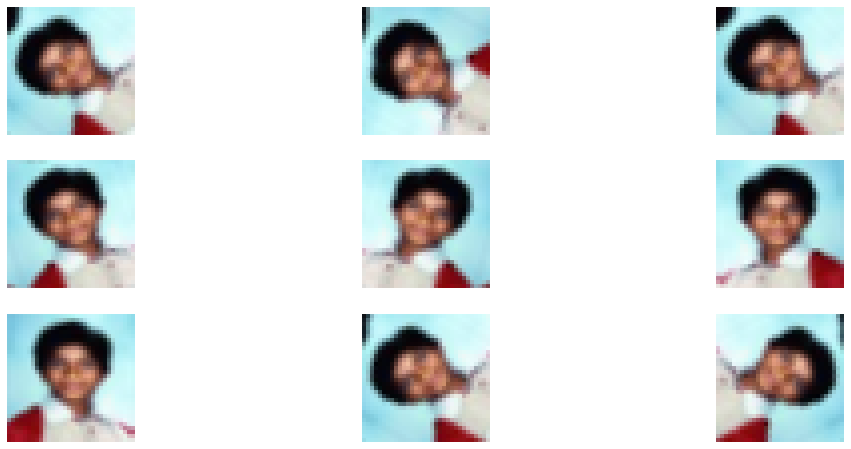

In [50]:
for image in X_train[:4]:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. ResNET50 has 50 layers, so setting the entire model's trainable flag to False will freeze all of them.

In [58]:
X_train.shape

(50000, 32, 32, 3)

In [60]:
base_model = keras.applications.ResNet50(weights=None,include_top = False,input_shape=(32,32,3))

In [61]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 2, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 1, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 1, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 1, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [62]:
base_model.trainable = False

In [63]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 2, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 1, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 1, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 1, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [65]:
inputs = tf.keras.Input(shape=(32,32,3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
hidden = keras.layers.Dense(256,activation="relu")(x)
hidden = keras.layers.Dropout(0.4)(hidden)
outputs = keras.layers.Dense(100,activation="softmax")(hidden)
model = tf.keras.Model(inputs, outputs)

In [ ]:
def build_model(input_shape, n_classes):
    base_model = densenet.DenseNet121(input_shape=input_shape,
                                      weights="imagenet",
                                      include_top=False,
                                      pooling='avg')

    for layer in base_model.layers[:-5]:
        layer.trainable = False

    for layer in base_model.layers[-5:]:
        layer.trainable = True

    x = base_model.output

    x = Dense(128)(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    

    return model

In [66]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

In [72]:
# Set checkpointer and train model
mdlCheck = keras.callbacks.ModelCheckpoint('cifar100_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
callBack = [mdlCheck,es]

In [81]:
history = model.fit(X_train, y_train, batch_size=128, shuffle=True, 
                    validation_data=(X_valid, y_valid), epochs=2, verbose=1,  
                    callbacks=callBack)

Epoch 1/2
391/391 [==============================] - ETA: 0s - loss: 7.8555 - accuracy: 0.0149
Epoch 1: val_accuracy improved from 0.01000 to 0.01187, saving model to cifar100_resnet.h5
391/391 [==============================] - 130s 329ms/step - loss: 7.8555 - accuracy: 0.0149 - val_loss: 4.5950 - val_accuracy: 0.0119
Epoch 2/2
391/391 [==============================] - ETA: 0s - loss: 4.5970 - accuracy: 0.0159
Epoch 2: val_accuracy improved from 0.01187 to 0.01850, saving model to cifar100_resnet.h5
391/391 [==============================] - 164s 419ms/step - loss: 4.5970 - accuracy: 0.0159 - val_loss: 4.5712 - val_accuracy: 0.0185


**Remember**: 
Here we are only focused on discussing what Tansfer Learning is and how to use pretrained model. You can follow Mini-Projects and other day notebooks to improve the model performance, since everything is already discussed. I trained only for 2 epochs, you can try training for 150 epochs by providing steps_by_epoch

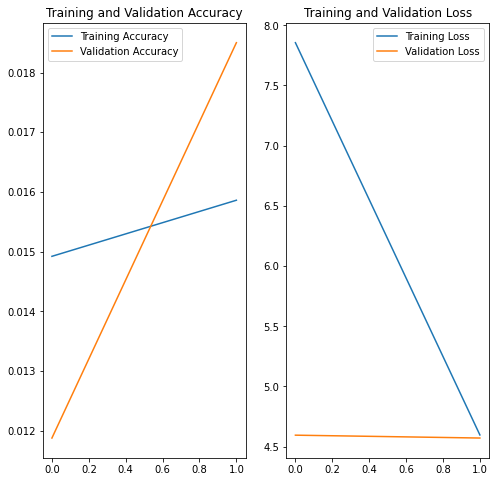

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
import pandas as pd

Text(0.5, 1.0, 'Model History')

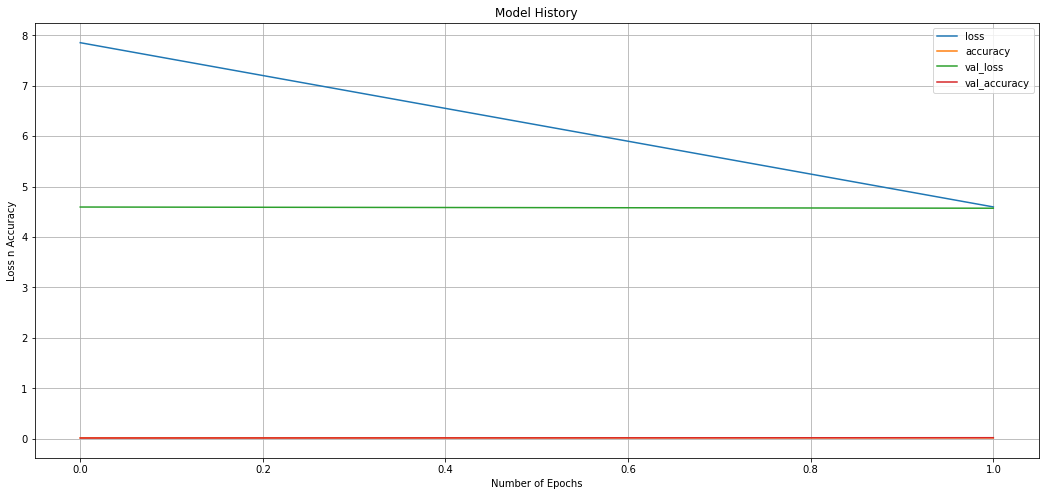

In [86]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss n Accuracy")
plt.title("Model History")

In [87]:
# Evaluate model on validation data
loss, acc = model.evaluate(X_test, y_test)

63/63 [==============================] - 5s 83ms/step - loss: 4.5779 - accuracy: 0.0150


In [88]:
# Get classification report
pred = np.argmax(model.predict(X_test), axis=1)
test_y = np.argmax(y_test, axis=1)

print(classification_report(test_y, pred, labels=list(range(len(cifar100_classes)))))

63/63 [==============================] - 5s 86ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.04      0.05      0.04        21
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        20
           6       0.03      0.10      0.04        20
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00        12
          12       0.00      0.00      0.00        21
          13       0.00      0.00      0.00        27
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00        18
          16       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
